In [144]:
import nltk
import sklearn
import pandas as pd
import numpy as np
from nltk.corpus import CategorizedPlaintextCorpusReader
from nltk import FreqDist
from nltk.corpus import stopwords
import string
import re
from nltk import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
# project module
from benchmark import get_benchmark, plot_confusion_matrix
from yellowbrick.text import FreqDistVisualizer
from sklearn.feature_extraction.text import CountVectorizer
from os import path
import os
import seaborn as sns
sns.set()
from wordcloud import WordCloud
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import learning_curve

In [136]:
# create the dataframe for companies for spliting
def create_dataframe(corpus, filtered_list = []):
    d = []
    for id_ in corpus.fileids():
        if id_ not in filtered_list:
            lang, innov = corpus.categories(id_)[0].split('/')
            if innov == 'innov':
                innov = 1
            else:
                innov = 0
            d.append({'id': id_, 'innov':innov, 'lang': lang})
    df = pd.DataFrame(d, columns=['id', 'innov', 'lang'])
    return df.set_index('id')

def corpus_to_df(corpus, language = 'all'):
    d = []
    for id in corpus.fileids():
        cat = corpus.categories(id)[0]
        lang, innov = cat.split('/')
        d.append([id, lang, innov])
    df = pd.DataFrame(d, columns=['id', 'lang', 'innov'])
    df['innov_'] = df['innov'].apply(lambda x: 1 if x=='innov' else 0)
    if language == 'all':
        return df
    elif np.any(df['lang'] == language):
        return df[df['lang'] == language]
    else:
        raise Exception('language is not found in the dataframe')
        
def plot_top_coef(name_coef_pair, title=''):
    plt.figure(figsize=(10,8.5))
    plt.title(title)
    plt.barh(*zip(*name_coef_pair))
    
def plot_top_features(vec, clf, selector=None):
    if selector:
            name_coef_pair = [(name, coef) for name, coef in zip(np.array(vec.get_feature_names())[selector.get_support()], clf.coef_[0])]
    else:
        name_coef_pair = [(name, coef) for name, coef in zip(vec.get_feature_names(), clf.coef_[0])]
    name_coef_pair = sorted(name_coef_pair, key = lambda x: x[1], reverse = True)
    name_coef_dict = {name: coef for name, coef in name_coef_pair}
    plot_top_coef(name_coef_pair[:50], title = 'top 50 words for innov')
    plot_top_coef(name_coef_pair[-50:], title = 'top 50 words for others')



NGRAM_RANGE = (1, 1)
TOP_K = 20000
TOKEN_MODE = 'word'
MIN_DOC_FREQ = 2
MAX_DOC_FREQ = 0.95
#use anova f score to select the feature
def vectorize(train_texts, train_labels, test_texts, use_selector=True, score_function = f_classif):
    kwargs = {
        'ngram_range' : NGRAM_RANGE,
        'dtype' : 'int32',
        'strip_accents' : 'unicode',
        'decode_error' : 'replace',
        'analyzer' : TOKEN_MODE,
        'min_df' : MIN_DOC_FREQ,
        'max_df' : MAX_DOC_FREQ
    }

    # Learn Vocab from train texts and vectorize train and val sets
    tfidf_vectorizer = TfidfVectorizer(**kwargs)
    x_train = tfidf_vectorizer.fit_transform(train_texts)
    x_test = tfidf_vectorizer.transform(test_texts)

    # Select best k features, with feature importance measured by f_classif
    if use_selector:
        selector = SelectKBest(score_function, k=min(TOP_K, x_train.shape[1]))
        selector.fit(x_train, train_labels)
        x_train = selector.transform(x_train).astype('float32')
        x_test = selector.transform(x_test).astype('float32')
#         scores = pd.DataFrame(list(zip(vectorizer.get_feature_names(), selector.scores_, selector.pvalues_)), 
#                                        columns=['ftr', 'score', 'pval'])
    return x_train, x_test, tfidf_vectorizer, selector if use_selector else None
    

    
def train_on(df, estimator=None):
    
    x_train, x_test, y_train, y_test = train_test_split(df['id'], df['innov_'], test_size=0.1, stratify = df['innov_'], random_state=42)
    
    count_v = CountVectorizer(binary=True, min_df = 0.01, max_df=0.95)
    x_train_count_b = count_v.fit_transform(corpus_cleaned.raw(id) for id in x_train)
    if estimator:
        lg = estimator
    else:
        lg = LogisticRegression(solver='liblinear', C=5, penalty='l2',max_iter=1000)
    lg.fit(x_train_count_b, y_train)
    x_test_count_b = count_v.transform(corpus_cleaned.raw(id) for id in x_test)
    print(classification_report(y_test, lg.predict(x_test_count_b),target_names=['others','innov']))
    plot_top_features(count_v, lg)
    plt.show()
    
    train_text = (corpus_cleaned.raw(id) for id in x_train)
    test_text = (corpus_cleaned.raw(id) for id in x_test)
    x_train_tfidf, x_test_tfidf, tfidf_v, selector = vectorize(train_text, y_train, test_text)
#     tfidf_v = TfidfVectorizer(min_df=0.01, max_df=0.95)
#     x_train_tfidf = tfidf_v.fit_transform(corpus_cleaned.raw(id) for id in x_train)
#     x_test_tfidf = tfidf_v.transform(corpus_cleaned.raw(id) for id in x_test)
    lg.fit(x_train_tfidf, y_train)
    print(classification_report(y_test, lg.predict(x_test_tfidf),target_names=['others','innov']))
    plot_top_features(tfidf_v, lg, selector = selector)
    plt.show()

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

def plot_result(results):
    indices = np.arange(len(results))

    results = [[x[i] for x in results] for i in range(4)]

    clf_names, score, training_time, test_time = results
    training_time = np.array(training_time) / np.max(training_time)
    test_time = np.array(test_time) / np.max(test_time)

    plt.figure(figsize=(12, 8))
    plt.title("Score")
    plt.barh(indices, score, .2, label="score", color='navy')
    plt.barh(indices + .3, training_time, .2, label="training time",
             color='c')
    plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
    plt.yticks(())
    plt.legend(loc='best')
    plt.subplots_adjust(left=.25)
    plt.subplots_adjust(top=.95)
    plt.subplots_adjust(bottom=.05)

    for i, c in zip(indices, clf_names):
        plt.text(-.3, i, c)

    plt.show()


In [137]:
doc_pattern = r'.*\.txt';
cat_pattern = r'([\w_/]+)/.*';
corpus_en_cleaned =CategorizedPlaintextCorpusReader('/Users/septem/Downloads/companies_cleaned/en/', doc_pattern, cat_pattern=cat_pattern)
corpus_nl_cleaned =CategorizedPlaintextCorpusReader('/Users/septem/Downloads/companies_cleaned/nl/', doc_pattern, cat_pattern=cat_pattern)
corpus_cleaned = CategorizedPlaintextCorpusReader('/Users/septem/Downloads/companies_cleaned/', doc_pattern, cat_pattern = cat_pattern)
len(corpus_en_cleaned.fileids()), len(corpus_nl_cleaned.fileids())

(900, 3884)

In [138]:
df_en = corpus_to_df(corpus_cleaned, language= 'en')
df_en.head()
# y = df_en['innov'].apply(lambda x: 1 if x == 'innov' else 0)
# sss = StratifiedShuffleSplit(n_splits=10,random_state = 42)
# train_index, test_index = next(sss.split(df_en['id'], df_en['innov']))

,id,lang,innov,innov_
0,en/innov/10000232.txt,en,innov,1
1,en/innov/10000364.txt,en,innov,1
2,en/innov/10010653.txt,en,innov,1
3,en/innov/10013385.txt,en,innov,1
4,en/innov/10025316.txt,en,innov,1


# english

              precision    recall  f1-score   support

      others       0.44      0.26      0.33        31
       innov       0.68      0.83      0.75        59

    accuracy                           0.63        90
   macro avg       0.56      0.54      0.54        90
weighted avg       0.60      0.63      0.60        90



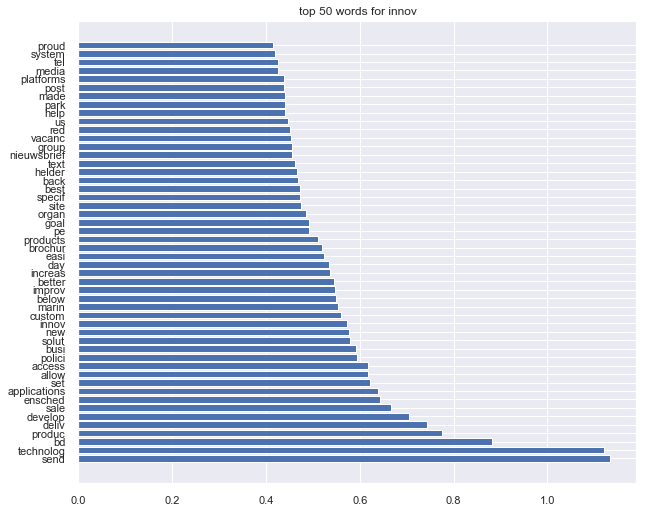

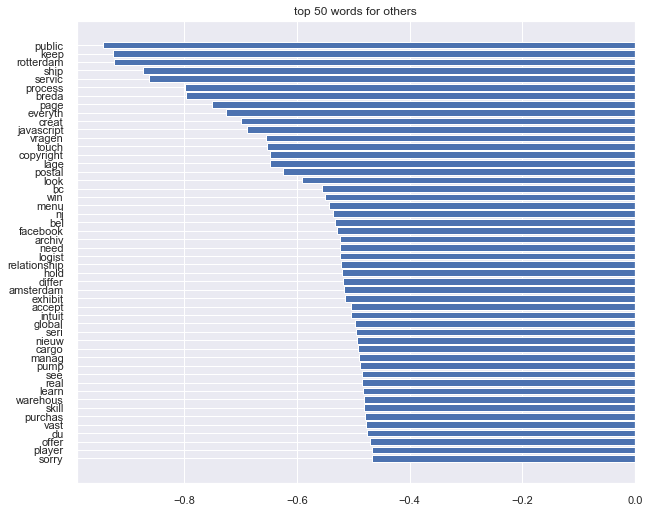

/Users/septem/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1813: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


              precision    recall  f1-score   support

      others       0.50      0.06      0.11        31
       innov       0.66      0.97      0.79        59

    accuracy                           0.66        90
   macro avg       0.58      0.52      0.45        90
weighted avg       0.61      0.66      0.55        90



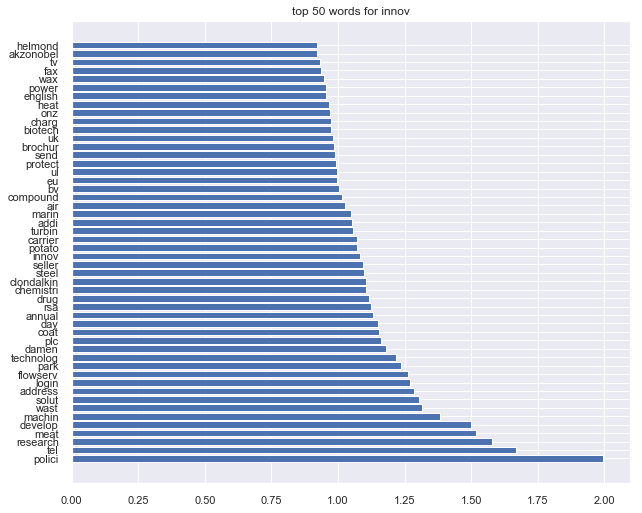

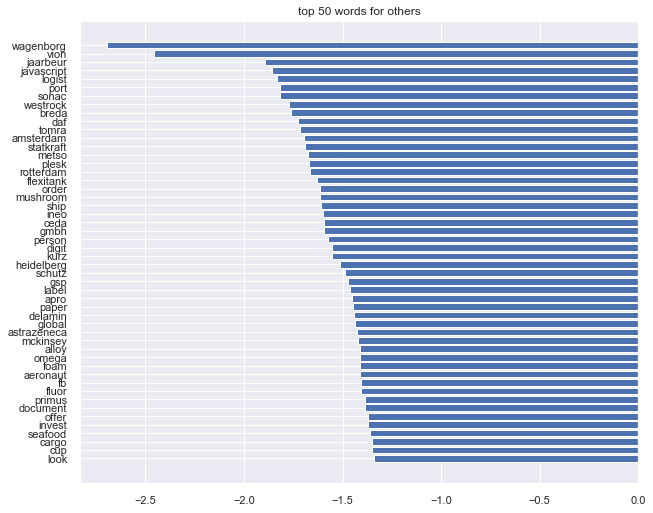

In [139]:
train_on(df_en)

# dutch

In [20]:
df_nl = corpus_to_df(corpus_cleaned, language= 'nl')
df_nl.head()

,id,lang,innov,innov_
900,nl/innov/10000836.txt,nl,innov,1
901,nl/innov/10001247.txt,nl,innov,1
902,nl/innov/10002685.txt,nl,innov,1
903,nl/innov/10002790.txt,nl,innov,1
904,nl/innov/10003401.txt,nl,innov,1


              precision    recall  f1-score   support

      others       0.54      0.54      0.54       187
       innov       0.57      0.57      0.57       202

    accuracy                           0.56       389
   macro avg       0.55      0.55      0.55       389
weighted avg       0.56      0.56      0.56       389



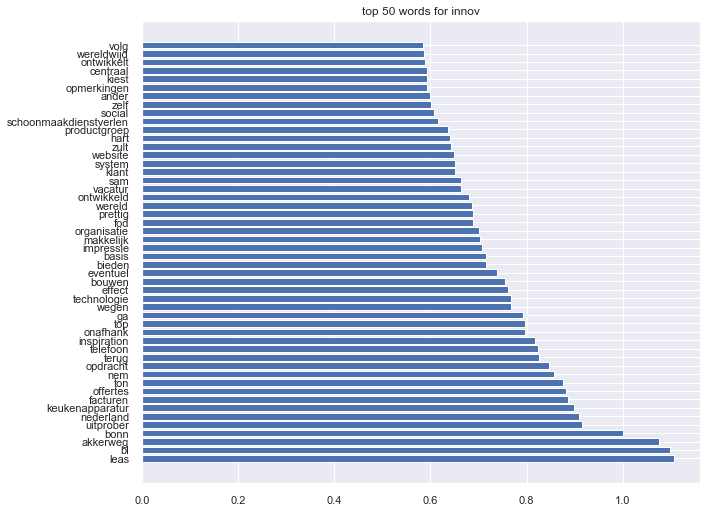

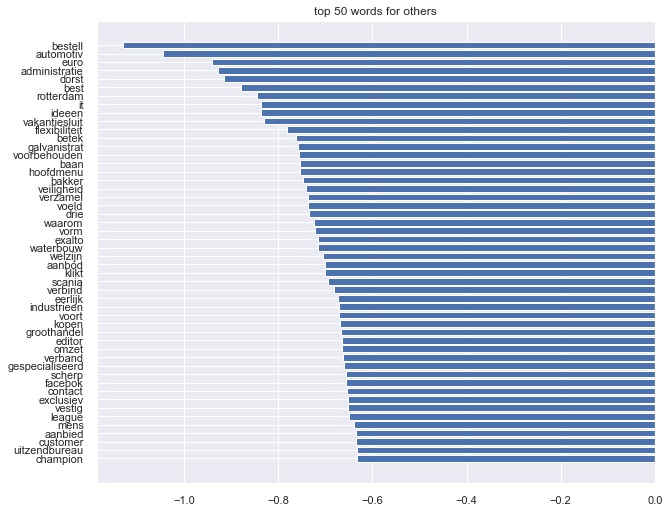

              precision    recall  f1-score   support

      others       0.60      0.53      0.57       187
       innov       0.61      0.67      0.64       202

    accuracy                           0.61       389
   macro avg       0.61      0.60      0.60       389
weighted avg       0.61      0.61      0.60       389



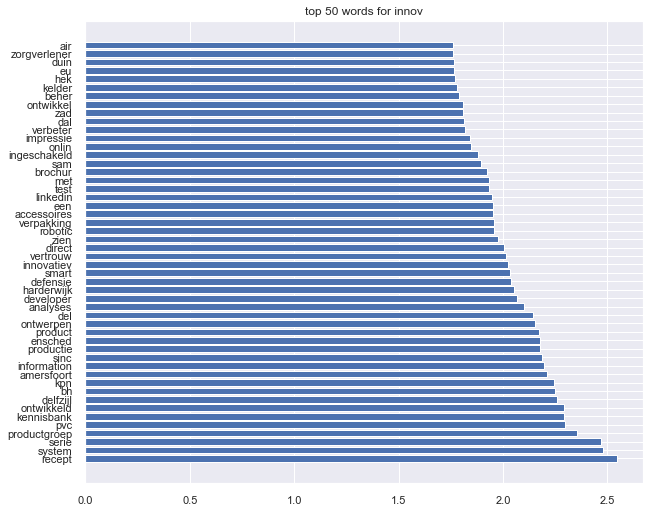

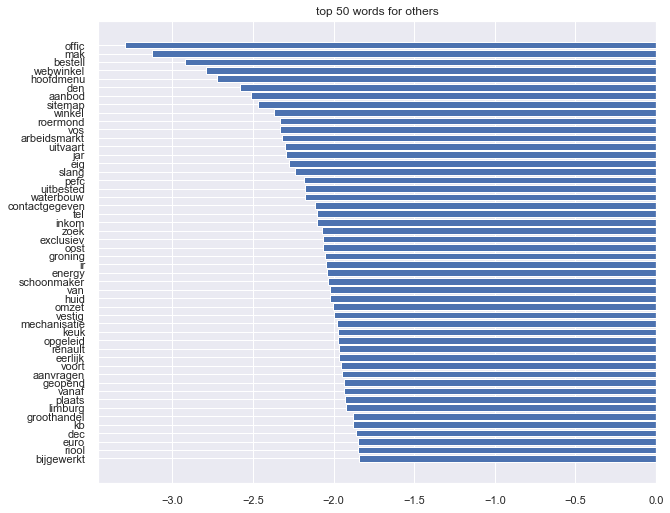

In [27]:
train_on(df_nl)

              precision    recall  f1-score   support

      others       0.53      0.53      0.53       187
       innov       0.56      0.56      0.56       202

    accuracy                           0.54       389
   macro avg       0.54      0.54      0.54       389
weighted avg       0.55      0.54      0.55       389



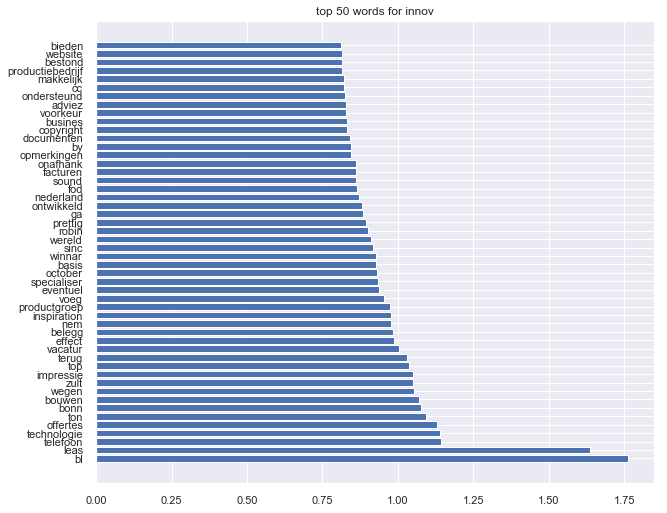

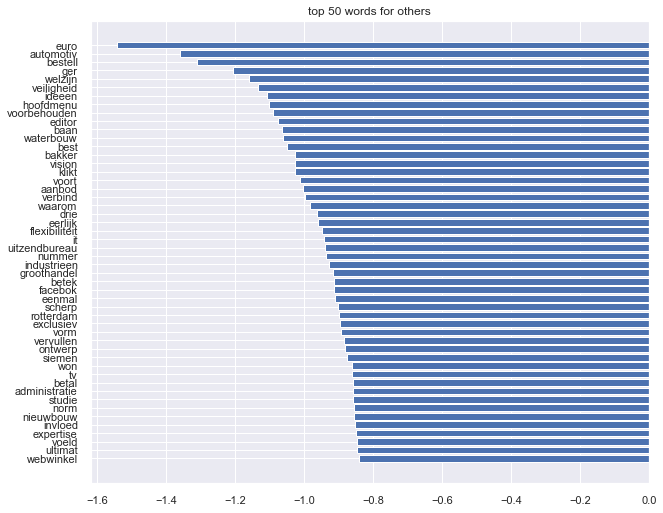

/Users/septem/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1813: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


              precision    recall  f1-score   support

      others       0.67      0.55      0.60       187
       innov       0.64      0.75      0.69       202

    accuracy                           0.65       389
   macro avg       0.66      0.65      0.65       389
weighted avg       0.66      0.65      0.65       389



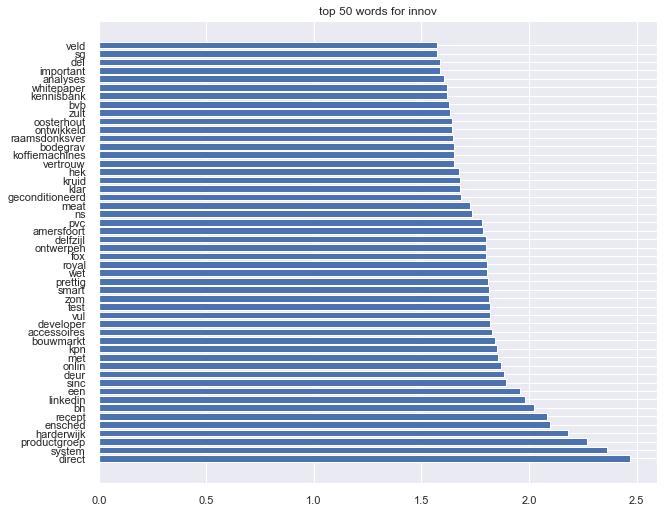

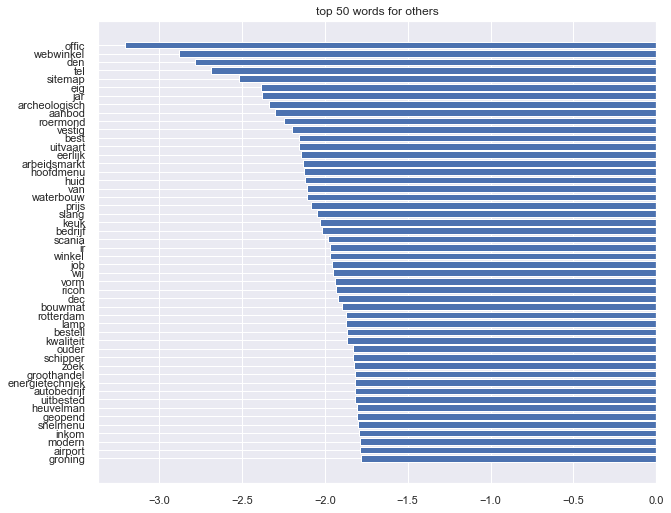

In [128]:
train_on(df_nl)

# combined

In [6]:
df = corpus_to_df(corpus_cleaned)

              precision    recall  f1-score   support

      others       0.57      0.55      0.56       219
       innov       0.63      0.65      0.64       263

    accuracy                           0.60       482
   macro avg       0.60      0.60      0.60       482
weighted avg       0.60      0.60      0.60       482



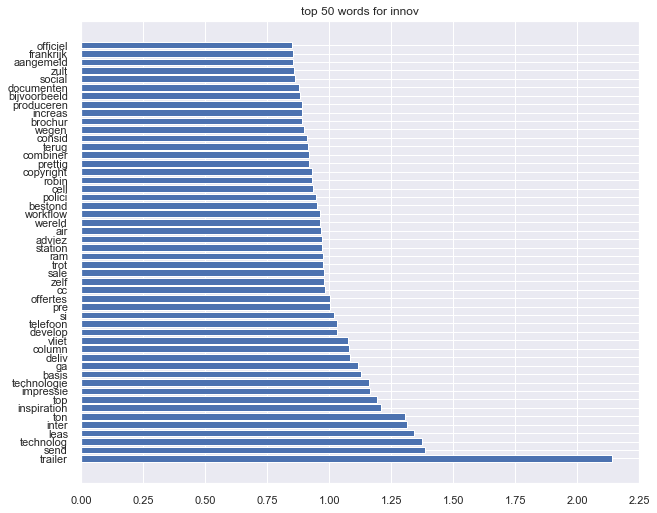

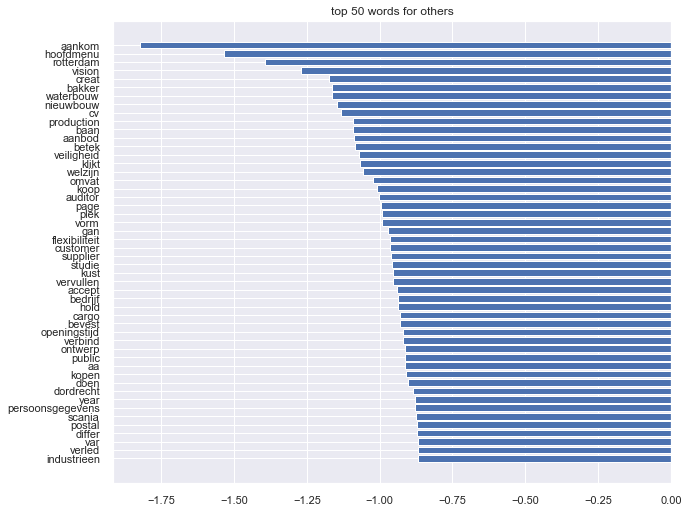

/Users/septem/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1813: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


              precision    recall  f1-score   support

      others       0.60      0.49      0.54       219
       innov       0.63      0.73      0.68       263

    accuracy                           0.62       482
   macro avg       0.62      0.61      0.61       482
weighted avg       0.62      0.62      0.62       482



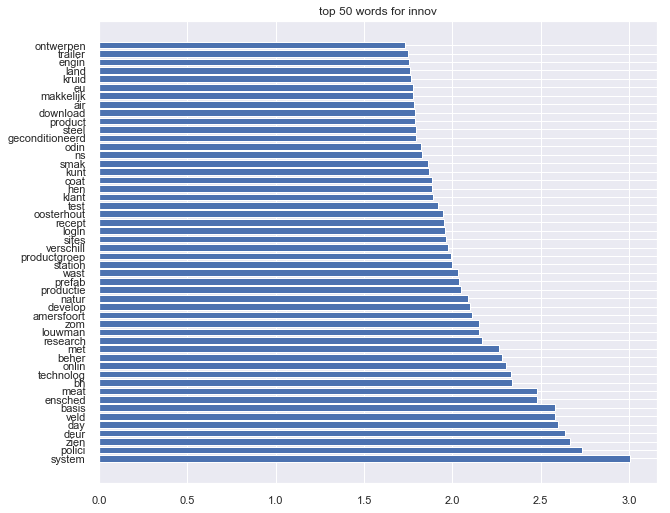

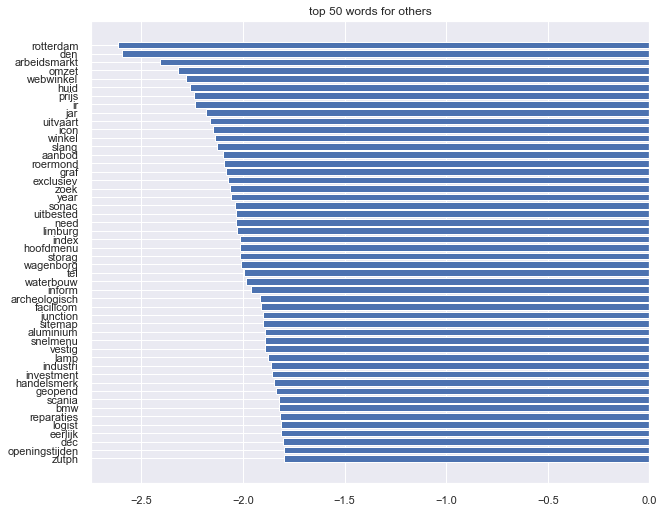

In [129]:
train_on(df)

# grid search

In [8]:
x_train, x_test, y_train, y_test = train_test_split(df['id'], df['innov_'], test_size=0.1, stratify = df['innov_'], random_state=42)
tfidf = TfidfVectorizer()
x_train_tfidf = tfidf.fit_transform(corpus_cleaned.raw(id) for id in x_train)
x_test_tfidf = tfidf.transform(corpus_cleaned.raw(id) for id in x_test)

In [121]:
#grid search:
#warning: takes time, but can load from drive
def hypertuning(x_train, y_train):
    logreg = LogisticRegression(n_jobs=-1, max_iter= 100)
    grid={"C":np.logspace(-3,3,7)}# l1 lasso l2 ridge
    logreg_cv=GridSearchCV(logreg,grid,cv=5)
    logreg_cv.fit(x_train,y_train)
    return logreg_cv
logreg_cv = hypertuning(x_train_tfidf, y_train)
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1.0}
accuracy : 0.6200184438101617


In [129]:
with open('log_reg_best.pickle', 'wb') as f:
    pickle.dump(logreg_cv.estimator, f)

In [140]:
with open('./pickle/log_reg_best.pickle', 'rb') as f:
    _estimator = pickle.load(f)

              precision    recall  f1-score   support

      others       0.53      0.32      0.40        31
       innov       0.70      0.85      0.77        59

    accuracy                           0.67        90
   macro avg       0.62      0.59      0.58        90
weighted avg       0.64      0.67      0.64        90



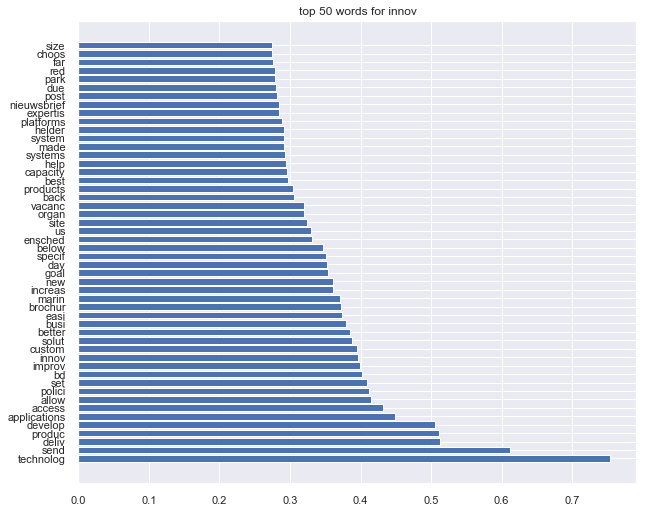

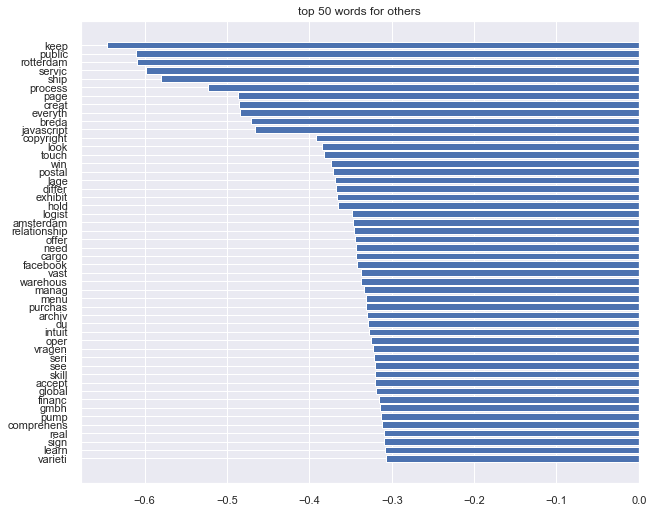

/Users/septem/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1813: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


              precision    recall  f1-score   support

      others       0.50      0.03      0.06        31
       innov       0.66      0.98      0.79        59

    accuracy                           0.66        90
   macro avg       0.58      0.51      0.42        90
weighted avg       0.60      0.66      0.54        90



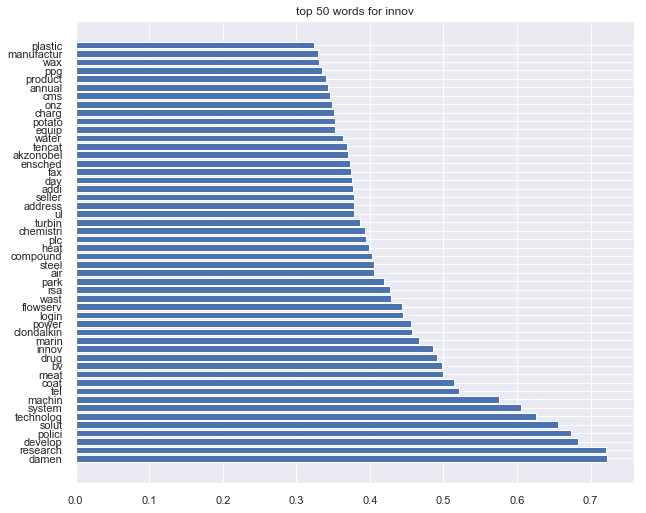

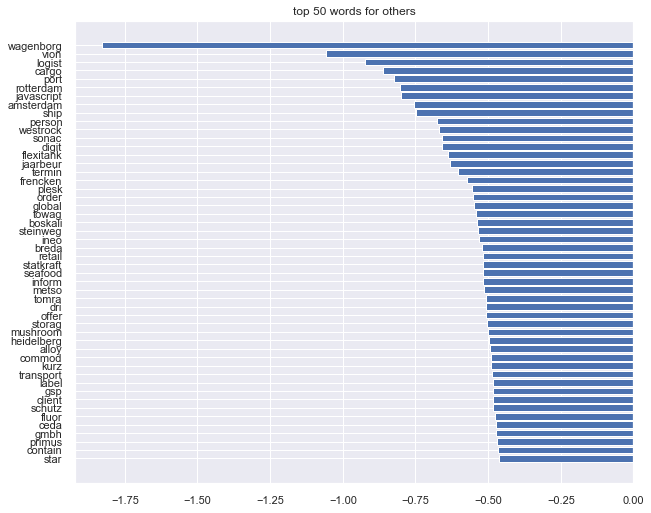

In [141]:
train_on(df_en, _estimator)

              precision    recall  f1-score   support

      others       0.53      0.52      0.53       187
       innov       0.56      0.57      0.57       202

    accuracy                           0.55       389
   macro avg       0.55      0.55      0.55       389
weighted avg       0.55      0.55      0.55       389



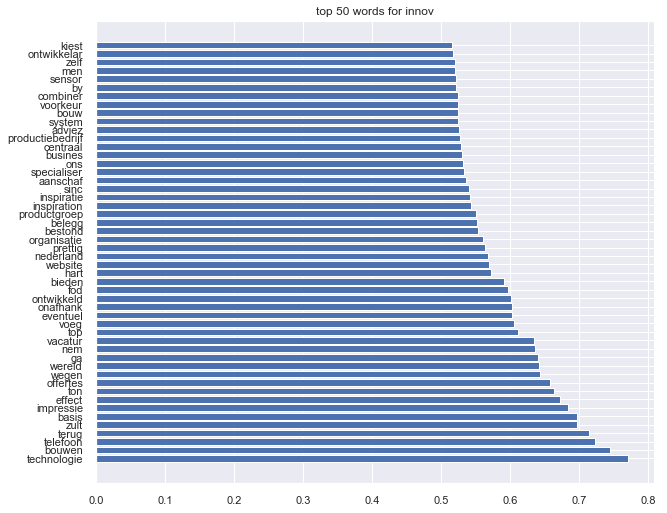

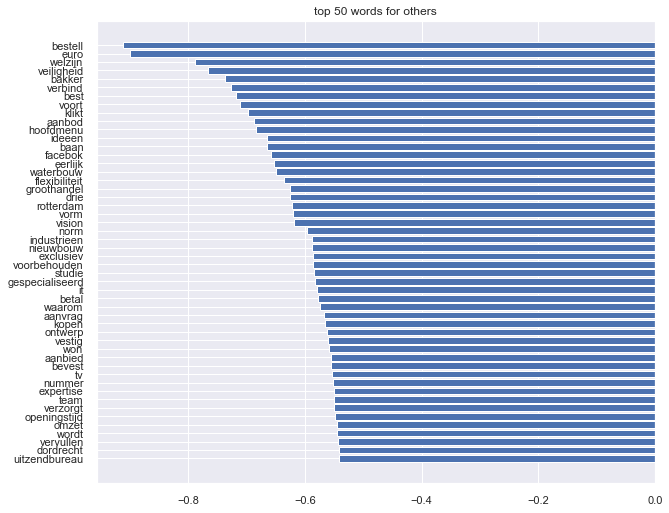

/Users/septem/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1813: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


              precision    recall  f1-score   support

      others       0.70      0.56      0.62       187
       innov       0.66      0.78      0.71       202

    accuracy                           0.67       389
   macro avg       0.68      0.67      0.67       389
weighted avg       0.68      0.67      0.67       389



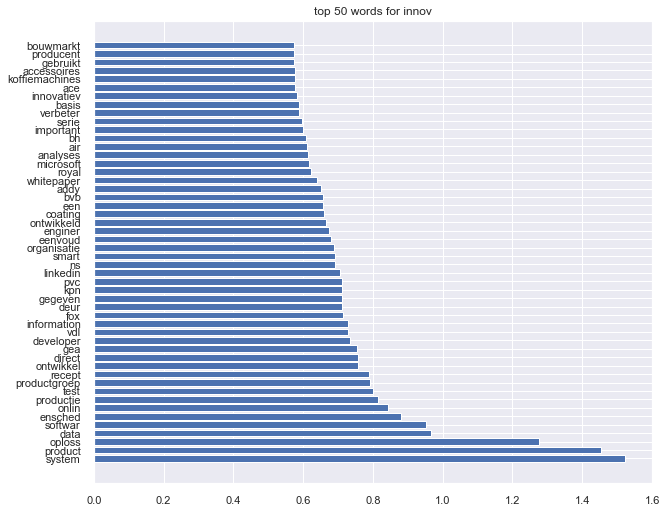

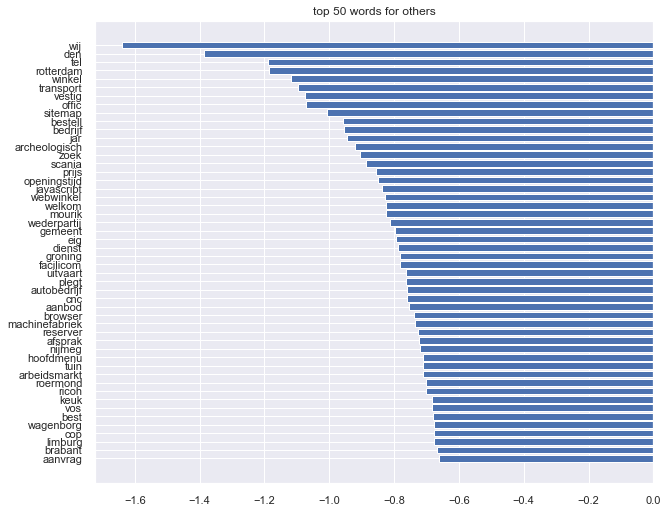

In [142]:
train_on(df_nl, _estimator)

              precision    recall  f1-score   support

      others       0.55      0.51      0.53       219
       innov       0.62      0.66      0.64       263

    accuracy                           0.59       482
   macro avg       0.58      0.58      0.58       482
weighted avg       0.59      0.59      0.59       482



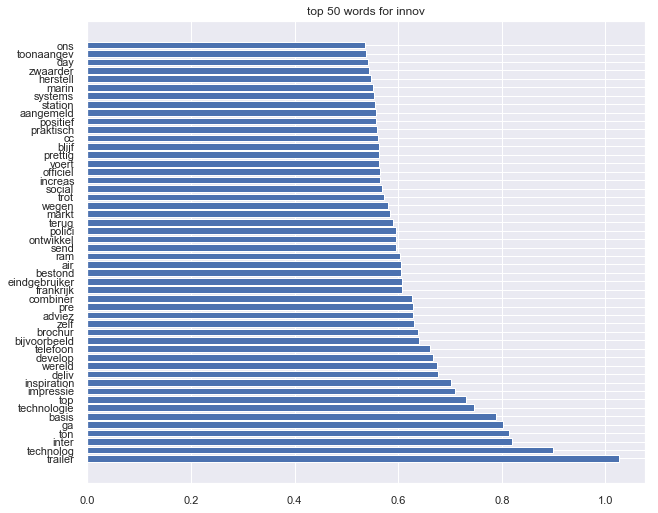

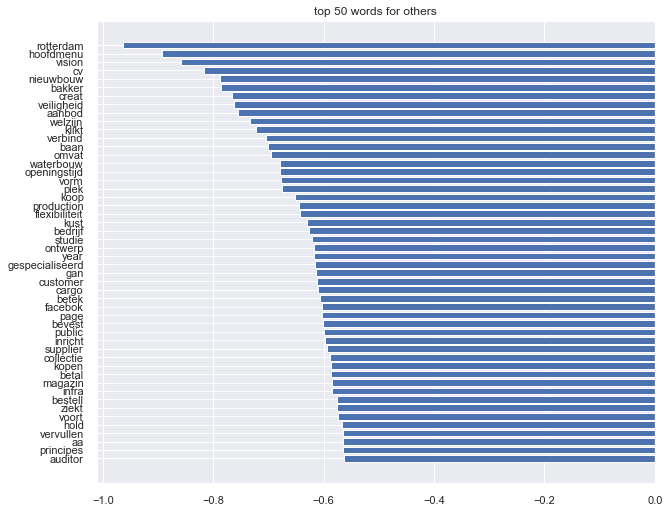

/Users/septem/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1813: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


              precision    recall  f1-score   support

      others       0.68      0.47      0.55       219
       innov       0.65      0.82      0.72       263

    accuracy                           0.66       482
   macro avg       0.66      0.64      0.64       482
weighted avg       0.66      0.66      0.65       482



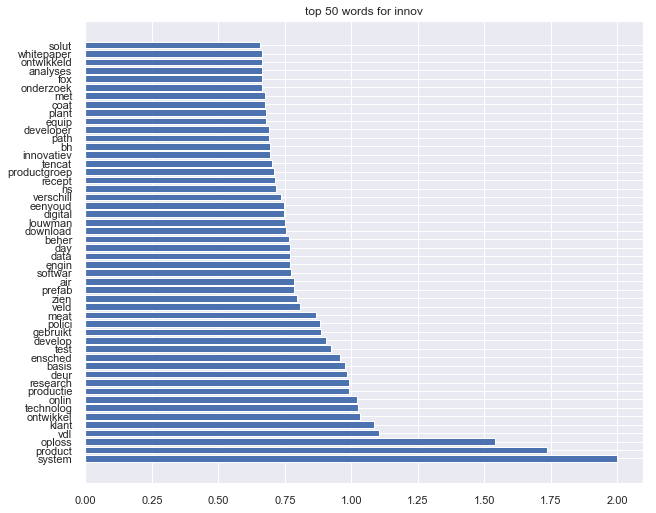

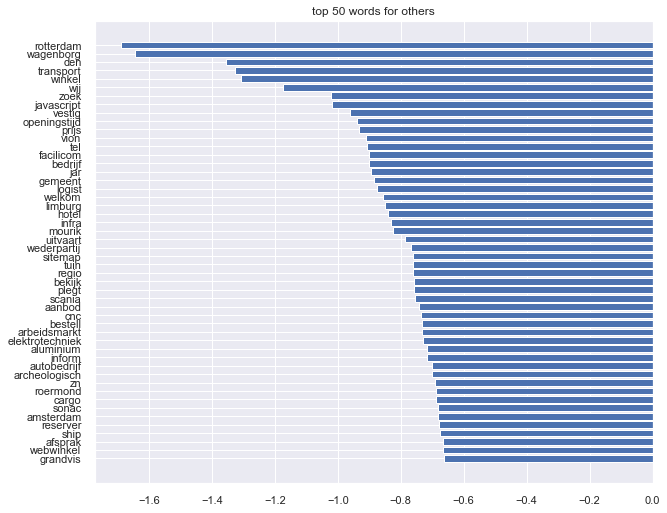

In [134]:
train_on(df, _estimator)

<module 'matplotlib.pyplot' from '/Users/septem/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

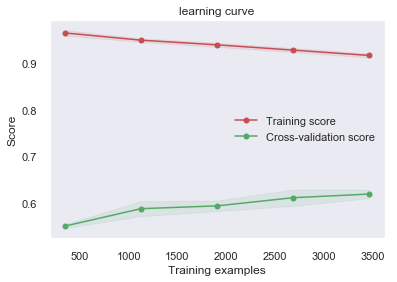

In [145]:
plot_learning_curve(_estimator, 'learning curve', x_train_tfidf, y_train)